## Building a Cortex Certifai scan programatically

In this notebook we'll build up a scan definition from first principles, against a local model trained within the notebook. We will then run that scan and save its results. 

- Load the dataset and model from disk
- Create scan defintion using Certifai Builder Api
- Refer to the [Cortex Certifai documentation](https://cognitivescale.github.io/cortex-certifai/docs/about) for detailed information about Cortex Certifai.
- Refer to [Cortex Certifai Examples Github](https://github.com/CognitiveScale/cortex-certifai-examples) for more self start tutorials

*Please Note*: this notebook assumes: 
- trained model and dataset is available within the the environment
- Cortex Certifai toolkit and model dependencies are installed


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue, CertifaiModelMetric,
                                      CertifaiFeatureDataType,CertifaiFeatureSchema, CertifaiDataSchema,CertifaiFeatureRestriction)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder
import joblib

In [2]:
# check required packages and their version
import sklearn as scikit
print(f'sklearn version is {scikit.__version__}')
print(f'numpy version is {np.__version__} ')
!certifai --version

sklearn version is 0.23.1
numpy version is 1.19.1 
Certifai version: 1.3.3
Scanner build: 1.3.3-159-ga98e943b
Console build: 1.3.3-192-ge7163f9


In [3]:
seed = 42
np.random.seed(seed)


### Load pre-trained model from disk along with encoder (if present)

- replace model_path variable below to point to stored model binary on disk


In [4]:
# load model 
model_path = 'models/german_credit_multiclass.joblib'
print(f'loading {model_path}')
try:
    model = joblib.load(model_path)
except FileNotFoundError as e:
    print(f'model `{model_path}` not found. Looks like model has not been trained or file location is wrong')
    raise Exception(str(e))
print(model)

loading models/german_credit_multiclass.joblib
Pipeline(steps=[('full_pipeline',
                 Pipeline(steps=[('transformer',
                                  TransformerCustom(cat_columns=None,
                                                    data_encoded=None,
                                                    normalize=None,
                                                    string_equivalence=None))])),
                ('model',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': (0.5, 1.0, 2.0),
                                          'max_iter': [1000],
                                          'solver': ['lbfgs']}))])


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


In [5]:
base_path = '../..'
all_data_file = f"{base_path}/datasets/german_credit_eval_multiclass_encoded.csv"

df = pd.read_csv(all_data_file)

one_hot_encoded_cat_cols = [
         'checkingstatus',
         'others',
         'age',
         'job',
         'employ',
         'property',
         'foreign',
         'history',
         'savings',
         'purpose',
         'housing'       
        ]

target_encoded_cat_cols = ['otherplans', 'status', 'telephone']
value_encoded_cat_cols =  []
label_column = 'outcome'


In [6]:
# currently Certifai doesn't natively support TargetEncoded categoricals features, 
# built-in support will be added in the next release
# this is a workaround for time being
# for Certifai to deal with floating point categoricals(target encoded),
# we need to covert targeted encoded cols to string
# we will be passing this dataframe to certifai for evaluation(see Adding Certifai Evaluation section below)

df_st = df.copy()
decimals = 3    
df_st[target_encoded_cat_cols] = df[target_encoded_cat_cols].apply(lambda x: round(x, decimals)).astype(str)

###  target_encoded string categorical to floating point encoding

In [7]:
%%writefile encoder.py
class Encoder:
    def __init__(self, X, target_encoded_cols):
        self.indx = [X.columns.get_loc(c) for c in target_encoded_cols]
    
    def __call__(self,X):
        X[:,self.indx] = X[:,self.indx].astype(float)
        return X

Overwriting encoder.py


In [8]:
# create the encoder callable(on the new dataFrame) to be passed to certifai
# this is to convert target_encoded strings in new dataframe back to floating points 
# since model is trained on target encoded features(floating points)
from encoder import Encoder
y = df_st[label_column]
X = df_st.drop(label_column,axis=1)
encoder = Encoder(X,target_encoded_cat_cols)

### Load Dataset and create one-hot feature-value mappings dict

- our dataset has one-hot feature values encoded as dataset columns along with target_encoded categoricals
- these one-hot encoded features present as column have column names delimited using `_` e.g. `age_<= 25 years`  `age_> 25 years` etc.
- we create one hot value mappings for each  one-hot encoded feature below
(e.g. `feature`: {`column_name_correponding_to_feature`: `features_value_in_column_for_given_feature`} )
    ```
    'age': {'age_<= 25 years': '<= 25 years', 
    'age_> 25 years': '> 25 years'}
   ```
- `one_hot_value_mappings` created above will be used later used to create `CertifaiDatasetSchema` 
> **Please Note**: this is only needed in-case dataset already has one-hot encoded feature as columns. Also if you already have the persisted mappings with same schema you can use that as well

In [9]:
from collections import defaultdict
mappings = defaultdict(list)
for col in df_st.columns.to_list():
    col_list = []
    feature_name,feature_value = col.split('_')[0], col.split('_')[1:]
    if feature_name in one_hot_encoded_cat_cols:
        if feature_value:
            mappings[feature_name].append('_'.join(feature_value))

# create a mapping from {feature -> {1-hot_column_name_in_csv: feature_value }} using the feature `mapping` list

"""
workclass:
     workclass_Local-gov -> Local-gov
     workclass_Self-emp-inc -> Self-emp-inc
"""
one_hot_value_mappings = {}
for k,v in mappings.items():
    one_hot_value_mappings[k] = { f'{k}_{cols}':cols  for cols in v} 

In [10]:
# above cell demonstrates how to create the mappings
# we use the persisted value mappings created using same code from above
# we also get the target_encoded mappings
import json
with open('../dataset_generation/cat_mappings.json', 'r') as fl:
    mappings = json.load(fl)   
print(mappings.keys())
one_hot_value_mappings = mappings.get('one_hot_encoded_mappings')
target_mappings = mappings.get('target_encoded_mappings')
print(f'---------\ntarget encoded value mappings ->\n{target_mappings}')


dict_keys(['one_hot_encoded_mappings', 'target_encoded_mappings'])
---------
target encoded value mappings ->
{'status': {'male : single': 1.602189781021898, 'female : divorced/separated/married': 1.7258064516129032, 'male : married/widowed': 1.5978260869565217, 'male : divorced/separated': 1.76}, 'telephone': {'phone - none': 1.7147651006711409, 'phone - yes, registered under the customers name': 1.5495049504950495}, 'otherplans': {'none': 1.6474201474201475, 'stores': 1.5957446808510638, 'bank': 1.669064748201439}}


## Certifai Evaluation Setup

### create Certifai model proxy

- [CertifaiPredictorWrapper](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref-1.3.2/certifai.scanner.builder.html?highlight=certifaipredictorwrapper#certifai.scanner.builder.CertifaiPredictorWrapper) api is used to wrap model objects with encoder/decoder callables
- if model has encoding, decoding capabilities built into it, `encoder`/`decoder` kwargs need not be provided

In [11]:
model_proxy = CertifaiPredictorWrapper(model,encoder=encoder)

### test wrapped model_proxy predicts

In [12]:
# # test to assert wrapped certifai model predicts == raw model predicts
assert (model_proxy.model.predict(encoder(X[:10].values)) == 
        model.predict(df.drop(label_column, axis=1)[:10].values)).all


### define  Certifai task type

- CertifaiTaskOutcomes : Cortex Certifai supports classification as well as regression models. Here we have an example of multiclass classificaton (e.g. Determine whether a loan should be granted)
- CertifaiOutcomeValue : define the outcomes possible from the model predictions. here we have a multiclass classification model that predicts whether loan will be 
- `granted`,
- `denied` or sent for
- `further inspection`


Note: Please refer to Certifai Api [docs](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref/certifai.scanner.builder.html) for more details

In [13]:
# Create Certifai evaluation task and add that to scan object
# First define the possible prediction outcomes

task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied', favorable=False),
        CertifaiOutcomeValue(3, name='further inspection', favorable=False)
    ],
    favorable_outcome_group_name = 'Loan Granted',
    unfavorable_outcome_group_name = 'Loan Denied of subject to futher inspection'
),
                     
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('german_credit_multiclass',
                                  prediction_task=task)

### add the model to be evaluated from above

In [14]:
first_model = CertifaiModel('german_credit_multiclass', local_predictor=model_proxy)
scan.add_model(first_model)

### create `CertifaiFeatureSchema` using categorical mappings dict from above

- for one-hot encoded features we use `one_hot_value_mappings` from above to let Certifai know the different features values along with data types for that particular feature
- for target encoded and value encoded features we let Certifai know their unique sets of values
- define [CertifaiFeatureDataType](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref-1.3.2/certifai.scanner.builder.html?highlight=certifaifeaturedatatype#certifai.scanner.builder.CertifaiFeatureDataType) for categorical features
- define [CertifaiFeatureSchema](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref-1.3.2/certifai.scanner.builder.html?highlight=certifaifeatureschema#certifai.scanner.builder.CertifaiFeatureSchema) for the datatype created above
- add the schema to [CertifaiDataSchema](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref-1.3.2/certifai.scanner.builder.html?highlight=certifaidataschema#certifai.scanner.builder.CertifaiDataSchema)

In [15]:
cat_features = []
for feature in one_hot_encoded_cat_cols + target_encoded_cat_cols + value_encoded_cat_cols:
    if feature in one_hot_value_mappings:
        data_type = CertifaiFeatureDataType.categorical(value_columns=one_hot_value_mappings[feature].items())
        feature_schema = CertifaiFeatureSchema(name=feature,
                                               data_type=data_type)
        cat_features.append(feature_schema)

    elif feature in target_encoded_cat_cols:
        data_type = CertifaiFeatureDataType.categorical(values=sorted(list(map(lambda x: str(round(x,decimals)) ,target_mappings[feature].values()))))
        feature_schema = CertifaiFeatureSchema(name=feature,
                                               data_type=data_type)
    elif feature in df_st.columns:
        print(feature)
        data_type = CertifaiFeatureDataType.categorical(values=sorted(df_st[feature].unique().tolist()))
        feature_schema = CertifaiFeatureSchema(name=feature,
                                               data_type=data_type)
        cat_features.append(feature_schema)
        
# certifai dataset schema combining numerical categorical features and 1-hot features
schema = CertifaiDataSchema(features=cat_features)
scan.dataset_schema = schema   

### Add Certifai Evaluation 

In [16]:
# certifai evaluation setup

# Add the explanation dataset. Here we run explanations for first 100 rows from the dataset

expn_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.dataframe(df_st[:100]))
scan.add_dataset(expn_dataset)
scan.explanation_dataset_id = 'explanation'


# add the evaluation for performance, explainability, robustness, fairness
scan.add_evaluation_type('explanation')
scan.add_evaluation_type('explainability')
scan.add_evaluation_type('robustness')
scan.add_evaluation_type('fairness')
scan.add_metric(CertifaiModelMetric('accuracy', certifai_metric='accuracy'))
scan.atx_performance_metric = 'accuracy'
scan.add_evaluation_type('performance')


# add fairness features

# set fairness features
fairness_fields = ['status', 'age']

for feature in fairness_fields:
    scan.add_fairness_grouping_feature(CertifaiGroupingFeature(feature))

# add the evaluation dataset from dataframe loaded at the start of the notebook        
eval_dataset = CertifaiDataset('evaluation',
                           CertifaiDatasetSource.dataframe(df_st))
scan.add_dataset(eval_dataset)
scan.evaluation_dataset_id = 'evaluation'
scan.test_dataset_id = 'evaluation'

### specify target column if present in dataset

In [17]:
# since dataset has ground truth or `target` variable present in it we let certifai know of the outcome column
scan.dataset_schema.outcome_feature_name = label_column

### Initiate scan

In [18]:
# start the scan
result = scan.run(base_path='.' , write_reports=True)

Starting scan with model_use_case_id: 'german_credit_multiclass' and scan_id: '03eca3c9fcff'
[--------------------] 2020-08-06 18:14:54.154798 - 0 of 5 reports (0.0% complete) - Running explanation evaluation for model: german_credit_multiclass
[####----------------] 2020-08-06 18:15:28.526888 - 1 of 5 reports (20.0% complete) - Running explainability evaluation for model: german_credit_multiclass
[########------------] 2020-08-06 18:16:15.866147 - 2 of 5 reports (40.0% complete) - Running robustness evaluation for model: german_credit_multiclass


2020-08-06 18:16:45,358 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for '1.76' with 50 samples)


[############--------] 2020-08-06 18:16:45.341633 - 3 of 5 reports (60.0% complete) - Running fairness evaluation for model: german_credit_multiclass


2020-08-06 18:17:18,492 root   WARNING  Examples of protected class (3, '1.76') exhausted before convergence after 50 samples
2020-08-06 18:17:37,412 root   WARNING  Examples of protected class (3, '1.598') exhausted before convergence after 92 samples
2020-08-06 18:18:05,908 root   WARNING  Examples of protected class (11, '<= 25 years') exhausted before convergence after 190 samples
2020-08-06 18:18:25,393 root   WARNING  Examples of protected class (3, '1.726') exhausted before convergence after 309 samples
2020-08-06 18:18:44,225 root   WARNING  Examples of protected class (11, '> 25 years') exhausted before convergence after 810 samples
2020-08-06 18:18:44,226 root   WARNING  Examples of protected class (3, '1.602') exhausted before convergence after 548 samples


[################----] 2020-08-06 18:18:58.620854 - 4 of 5 reports (80.0% complete) - Running performance evaluation for model: german_credit_multiclass
[####################] 2020-08-06 18:18:58.633825 - 5 of 5 reports (100.0% complete) - Completed all evaluations


## Visualize Results

### fairness

In [19]:
df_fairness = construct_scores_dataframe(scores('fairness', result), include_confidence=True)
display(df_fairness)

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (1.598) upper bound,Group details (1.602),Group details (1.602) lower bound,Group details (1.602) upper bound,Group details (1.726),Group details (1.726) lower bound,Group details (1.726) upper bound,Group details (1.76),Group details (1.76) lower bound,Group details (1.76) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,71.992284,66.421858,77.449532,72.501783,66.586402,78.8155,0.113569,0.101267,...,0.063233,0.063375,0.057219,0.069925,0.094135,0.085244,0.103886,0.103846,0.080702,0.126923


###  (fairness) status burdens by model

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (1.598) upper bound,Group details (1.602),Group details (1.602) lower bound,Group details (1.602) upper bound,Group details (1.726),Group details (1.726) lower bound,Group details (1.726) upper bound,Group details (1.76),Group details (1.76) lower bound,Group details (1.76) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,71.992284,66.421858,77.449532,72.501783,66.586402,78.8155,0.113569,0.101267,...,0.063233,0.063375,0.057219,0.069925,0.094135,0.085244,0.103886,0.103846,0.080702,0.126923


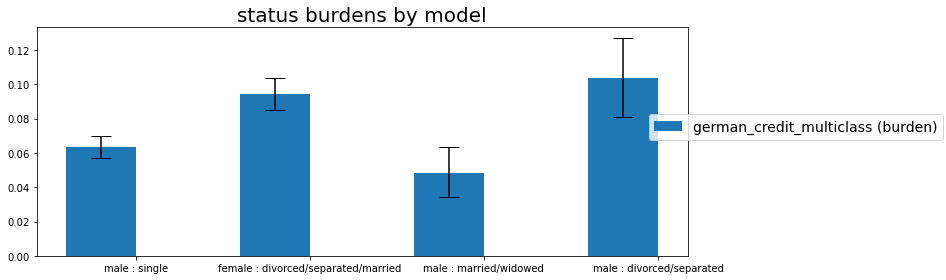

In [20]:
%matplotlib inline
display(df_fairness)

# since status is a target encoded variable;
# for plotting values in non-encoded space we make use of the `target_mappings` dict


groups_disp, groups  = list(target_mappings['status'].keys()), list(map(lambda x: round(x,decimals),target_mappings['status'].values()))



feature_scores = df_fairness[[f"Group details ({g})" for g in groups]]
feature_lower_bounds = df_fairness[[f + ' lower bound' for f in feature_scores]]
feature_upper_bounds = df_fairness[[f + ' upper bound' for f in feature_scores]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('status burdens by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(groups))+width)
ax.set_xticklabels(groups_disp)

for idx in range(len(df_fairness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(groups))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_fairness.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### (fairness) age burdens by model

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (1.598) upper bound,Group details (1.602),Group details (1.602) lower bound,Group details (1.602) upper bound,Group details (1.726),Group details (1.726) lower bound,Group details (1.726) upper bound,Group details (1.76),Group details (1.76) lower bound,Group details (1.76) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,71.992284,66.421858,77.449532,72.501783,66.586402,78.8155,0.113569,0.101267,...,0.063233,0.063375,0.057219,0.069925,0.094135,0.085244,0.103886,0.103846,0.080702,0.126923


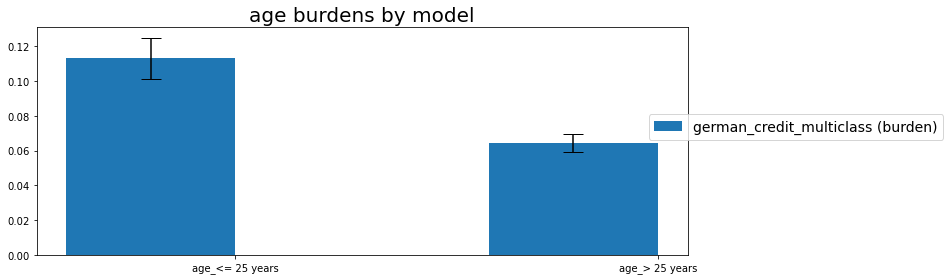

In [21]:
%matplotlib inline
display(df_fairness)
# since age is a one-hot encoded variable;
# for plotting values in non-encoded space we make use of the `one_hot_value_mappings` dict

groups_disp, groups  = list(one_hot_value_mappings['age'].keys()), list(one_hot_value_mappings['age'].values())

feature_scores = df_fairness[[f"Group details ({g})" for g in groups]]
feature_lower_bounds = df_fairness[[f + ' lower bound' for f in feature_scores]]
feature_upper_bounds = df_fairness[[f + ' upper bound' for f in feature_scores]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('age burdens by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(groups))+width)
ax.set_xticklabels(groups_disp)

for idx in range(len(df_fairness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(groups))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_fairness.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Feature Fairness by model 

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (1.598) upper bound,Group details (1.602),Group details (1.602) lower bound,Group details (1.602) upper bound,Group details (1.726),Group details (1.726) lower bound,Group details (1.726) upper bound,Group details (1.76),Group details (1.76) lower bound,Group details (1.76) upper bound
german_credit_multiclass (burden),german_credit_multiclass,burden,71.992284,66.421858,77.449532,72.501783,66.586402,78.8155,0.113569,0.101267,...,0.063233,0.063375,0.057219,0.069925,0.094135,0.085244,0.103886,0.103846,0.080702,0.126923


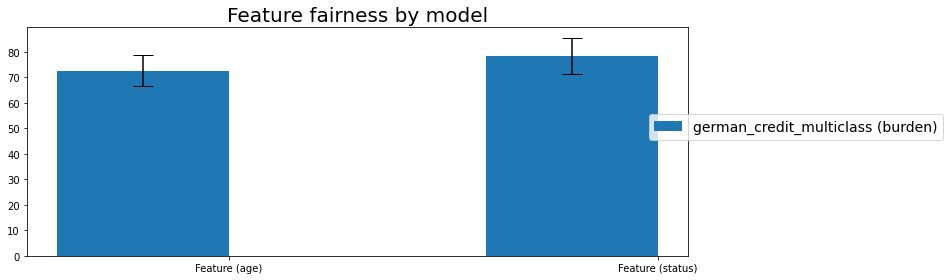

In [22]:
display(df_fairness)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (age)', 'Feature (status)']
feature_scores = df_fairness[features]
feature_lower_bounds = df_fairness[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_fairness[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_fairness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_fairness.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Robustness by model

- The following cell shows how to extract Certifai Robustness Score from the scan results object
- The high Robustness score indicates the given model needs to change larger no. of features to alter the prediction outcomes
- please refer to official documentation for [Certifai Robustness](https://cognitivescale.github.io/cortex-certifai/docs/factors/robustness)

,context,robustness,robustness lower bound,robustness upper bound
german_credit_multiclass,german_credit_multiclass,82.592993,78.495733,86.213649


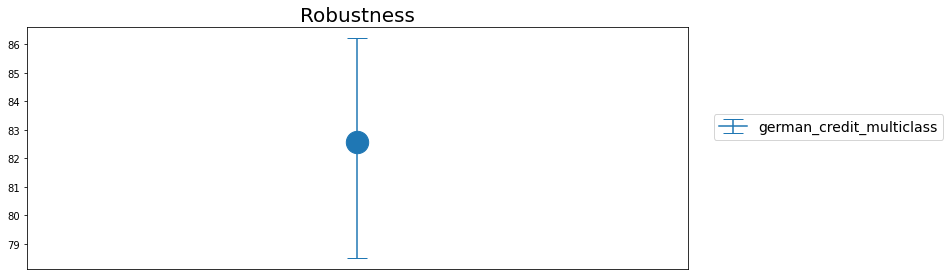

In [23]:
df_robustness = construct_scores_dataframe(scores('robustness', result), include_confidence=True)
display(df_robustness)

%matplotlib inline
import matplotlib.pyplot as plt

features = ['robustness']
feature_scores = df_robustness[features]
feature_lower_bounds = df_robustness[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_robustness[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Robustness', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_robustness)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.errorbar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df_robustness.index[idx],
            capsize=10)
    
    ax.scatter([width/2+idx*width+f_idx for f_idx in range(len(features))], central_values,s=500)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Explainability by model 

- the following cell shows how to extract Certifai Explainability Score from the scan results object
- please refer to official documentation for [Certifai Explainability](https://cognitivescale.github.io/cortex-certifai/docs/factors/explainability)

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
german_credit_multiclass,german_credit_multiclass,97.96875,82.03125,0.0,16.40625,1.5625,0.0,0.0,0.0,0.0,0.0,0.0


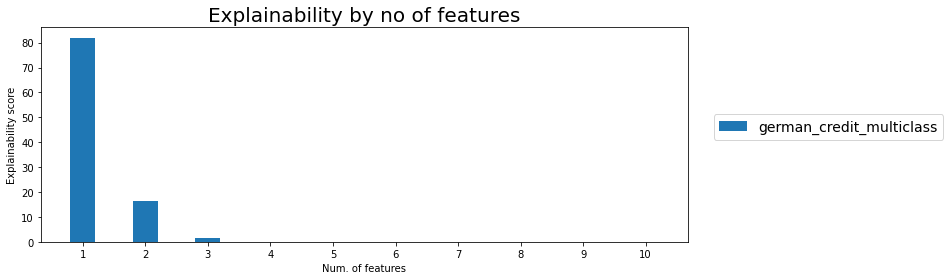

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

df_explainability= construct_scores_dataframe(scores('explainability', result), include_confidence=True)
display(df_explainability)


features = ['Num features (1)', 'Num features (2)', 'Num features (3)', 'Num features (4)', 'Num features (5)', 'Num features (6)', 'Num features (7)', 'Num features (8)', 'Num features (9)', 'Num features (10)']
features_disp = [i for i in range(1,11)]
feature_scores = df_explainability[features]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Explainability by no of features', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features_disp)
ax.set_xlabel("Num. of features")
ax.set_ylabel("Explainability score")

for idx in range(len(df_explainability)):
    central_values = list(feature_scores.iloc[idx])

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,align='edge',
            color=colors[idx],
            label=df_explainability.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()